### 本项目的目标在于分析并预测用户流失

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('AZwatch_churn.csv', index_col = 0)
df.head()

,subscriber_id,age_group,engagement_time,engagement_frequency,subscription_status
index,,,,,
0,14451,18-34,5.55,7,subscribed
1,18386,under 18,5.12,12,subscribed
2,12305,35 and over,4.25,4,churned
3,17546,18-34,8.54,15,subscribed
4,15399,18-34,12.12,20,subscribed


In [2]:
# Add a new column 'weekly_engagement'
df['weekly_engagement'] = df['engagement_time'] * df['engagement_frequency']

In [3]:
# Be familiar with dataset
print('Number of samples:', df.shape[0])
print(df.info())

Number of samples: 1000
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subscriber_id         1000 non-null   int64  
 1   age_group             1000 non-null   object 
 2   engagement_time       1000 non-null   float64
 3   engagement_frequency  1000 non-null   int64  
 4   subscription_status   1000 non-null   object 
 5   weekly_engagement     1000 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 54.7+ KB
None


### Step1 分析用户与用户流失情况
分析思路：

1. 人口统计学特征分析（年龄）

2. 用户行为分析（平均使用时长，周登录次数，活跃度）

#### 用户流失的总体情况

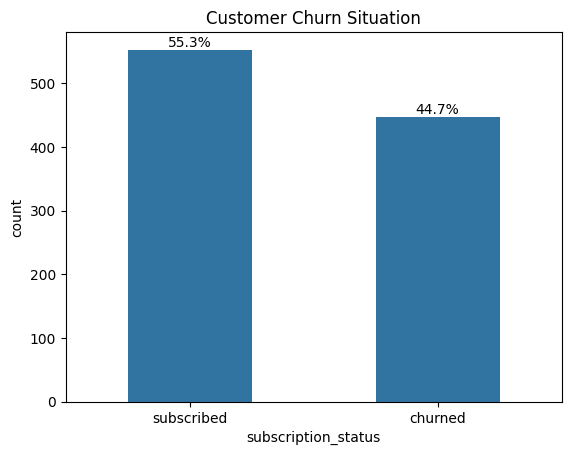

In [5]:
# The churn situation
ax = sns.countplot(x = df['subscription_status'], width = 0.5)
plt.title('Customer Churn Situation')
for p in ax.patches:
    count = p.get_height()
    perc = (count / len(df['subscription_status'])) * 100
    ax.annotate(
        f'{perc:.1f}%',
        (p.get_x() + p.get_width()/2, count),
        ha = 'center', va = 'bottom', fontsize = 10
    )
plt.show()

在一年使用期结束后，用户的退订率为44.7%

#### 年龄分布

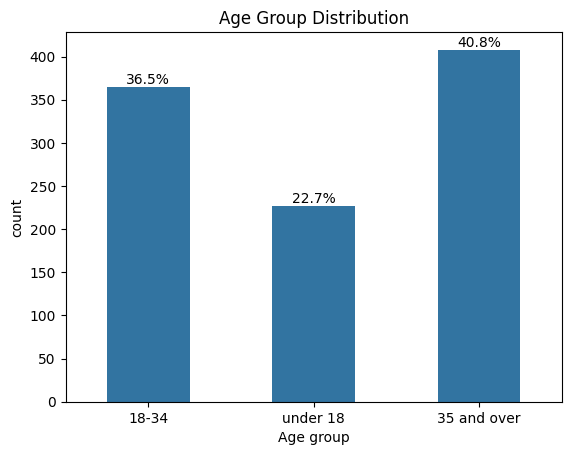

In [4]:
# The distribution of age group 
ax = sns.countplot(x = df['age_group'], width = 0.5)
for p in ax.patches:
    count = p.get_height()
    percentage = (count / len(df['age_group'])) * 100
    ax.annotate(f'{percentage:.1f}%',
               (p.get_x() + p.get_width()/2, p.get_height()),
               ha = 'center', va = 'bottom', fontsize = 10)
plt.xlabel('Age group')
plt.title('Age Group Distribution')
plt.show()

该流媒体平台订阅用户的主要年龄群为18-34岁和35岁及以上，共占比约77%。

### 待解决的代码问题：

ChatGPT提到可以用```from scipy.signal import find_peaks```自动找峰值

### 没解决
1. 搞不懂prominence
2. 在Google上查找的实现方法太麻烦

### 暂时解决方法
对float的数据round(0)，int的数据不存在下面提到的density点应该是3，但众数找出来是7的情况

In [17]:
# 查找众数/峰值
print(df['engagement_time'].round(0).value_counts().sort_values(ascending=False).head(5))
print(df['engagement_frequency'].value_counts().sort_values(ascending = False).head(5))

#  Check the statistics of two numerical variables
df[['engagement_time','engagement_frequency']].describe()

engagement_time
7.0    139
4.0    134
6.0    126
5.0    113
3.0    113
Name: count, dtype: int64
engagement_frequency
5    94
4    93
6    86
8    67
7    65
Name: count, dtype: int64


,engagement_time,engagement_frequency
count,1000.000000,1000.000000
mean,6.180030,9.978000
std,2.757166,6.236859
min,0.220000,0.000000
25%,3.917500,5.000000
50%,6.000000,8.000000
75%,8.110000,15.000000
max,16.980000,45.000000


In [7]:
df[['weekly_engagement']].describe()

,weekly_engagement
count,1000.000000
mean,67.113630
std,55.775103
min,0.000000
25%,21.107500
50%,50.530000
75%,101.880000
max,369.000000


In [7]:
# 利用find_peaks查找峰值
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

def get_kde_peak(series):
    kde = gaussian_kde(series)
    x_vals = np.linspace(series.min(), series.max(), 1000)
    y_vals = kde(x_vals)
    return y_vals

density = get_kde_peak(df['engagement_time'])
find_peaks(density)


(array([213, 367, 962]), {})

/var/folders/2x/v2nfhk6s183c6sb3zklf20300000gn/T/ipykernel_23560/1165496811.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['engagement time'])
/var/folders/2x/v2nfhk6s183c6sb3zklf20300000gn/T/ipykernel_23560/1165496811.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['engagement_frequency'])


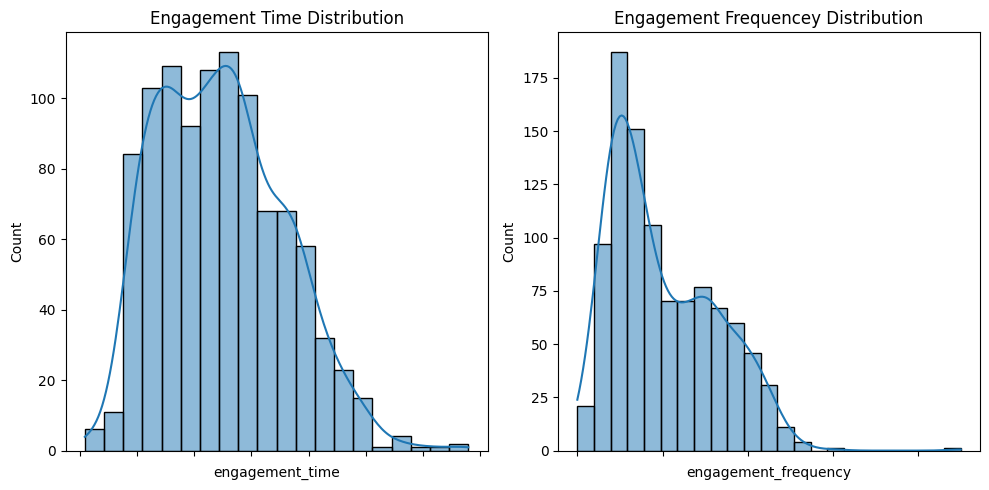

In [3]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

sns.histplot(x = df['engagement_time'], kde = True, ax = axs[0])
axs[0].set_title('Engagement Time Distribution')
axs[0].set_xticklabels(['engagement time'])

sns.histplot(x = df['engagement_frequency'], kde = True, ax = axs[1])
axs[1].set_title('Engagement Frequencey Distribution')
axs[1].set_xticklabels(['engagement_frequency'])

plt.tight_layout()
plt.show()

订阅者每次使用的平均时间范围（/分钟）为0-17分钟，其中平均值为6分钟，有两个峰值，分别集中在4分钟和7分钟。

订阅者每周登录的次数波动在0-45次，登录次数的中间值为每周8次，峰值为5。除此之外，需注意有较明显的右部极端值，需考虑是否在后续分析中移除。

/var/folders/2x/v2nfhk6s183c6sb3zklf20300000gn/T/ipykernel_20197/1091390378.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(['engagement time'])
/var/folders/2x/v2nfhk6s183c6sb3zklf20300000gn/T/ipykernel_20197/1091390378.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['engagement_frequency'])


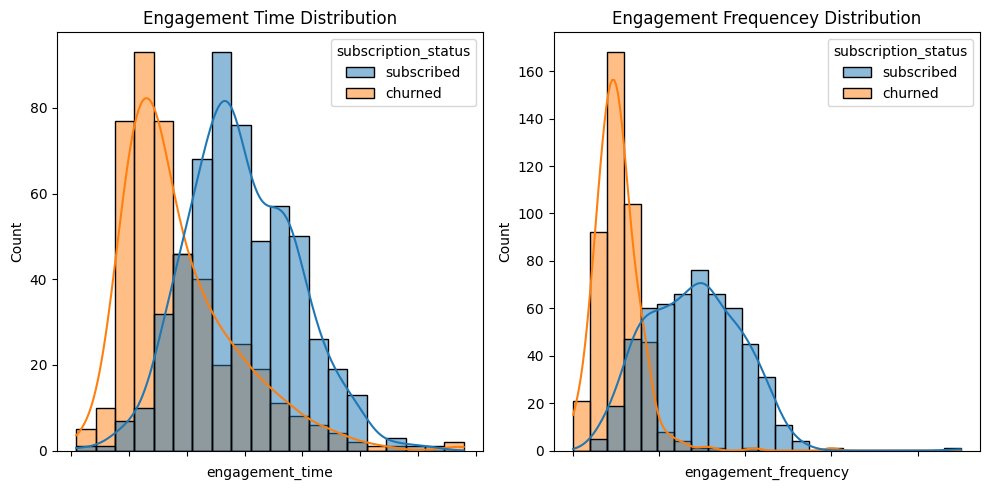

In [3]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

sns.histplot(x = df['engagement_time'], kde = True, ax = axs[0], hue = df['subscription_status'])
axs[0].set_title('Engagement Time Distribution')
axs[0].set_xticklabels(['engagement time'])

sns.histplot(x = df['engagement_frequency'], kde = True, ax = axs[1], hue = df['subscription_status'])
axs[1].set_title('Engagement Frequencey Distribution')
axs[1].set_xticklabels(['engagement_frequency'])

plt.tight_layout()
plt.show()

In [11]:
# Find the KDE peak
from scipy.stats import gaussian_kde

def get_kde_peak(series):
    kde = gaussian_kde(series) # fit the series into KDE model
    x_vals = np.linspace(series.min(), series.max(), 1000)
    y_vals = kde(x_vals)
    return x_vals[np.argmax(y_vals)]

print("Churned - engagement_time peak:", (get_kde_peak(churned['engagement_time'])).round(1))
print("Retained - engagement_time peak:", (get_kde_peak(retained['engagement_time'])).round(1))
print("Churned - engagement_frequency peak:", (get_kde_peak(churned['engagement_frequency'])).round(1))
print("Retained - engagement_frequency peak:", (get_kde_peak(retained['engagement_frequency'])).round(1))

Churned - engagement_time peak: 3.3
Retained - engagement_time peak: 6.7
Churned - engagement_frequency peak: 4.6
Retained - engagement_frequency peak: 14.8


```gaussian_kde``` takes in a series of data points and returns a smooth probability density function.It **returns a function** which can  give you the estimated density at any point x, **not a result**(doesn’t “know” where the highest peak is).Because KDE is continuous, **there are infinite possible x-values**, so you must **scan the curve yourself.**

```x_vals = np.linspace(a, b, 1000)``` creates 1000 evenly spaced points between a (minimum value of your data) and b (maximum).

How KDE works, or we can say, **How calculate KDE value at each x?** It estimates density **using kernel functions**(usually Gaussian/normal-shaped curves).

```y_vals = kde(x_vals)``` computes the density(KDE value) at each point.

```np.argmax(y_vals)``` finds the **index** where the KDE value is the highest.

### 待解决问题：
找使用时间的峰值代码，其结果和图像不符合。

### 原因：
当你使用```value_counts().idxmax()```，其计算的是你的数据集中单一某点的发生频率，所以很有可能出现以下的情况：

```[3.11, 3.12, 3.09, 2.99，2.98, 7.0，7.0] ```其**众数是7**。但这并不是你实际想要的，in practice, **我们想得到的结果是“数据在3附近集中。"**

So，in practice, we alway **use** KDE **density** to find KDE-estimated peaks, not actual frequency.
```from scipy.stats import gaussian_kde```

In [9]:
# 1. 拆分数据
churned = df[df['subscription_status'] == 'churned']
retained = df[df['subscription_status'] == 'subscribed']

# 2. 找峰值（众数）
peak1_fre = churned['engagement_frequency'].value_counts().idxmax()
peak1_time = churned['engagement_time'].value_counts().idxmax()
peak0_fre = retained['engagement_frequency'].value_counts().idxmax()
peak0_time = retained['engagement_time'].value_counts().idxmax()
print(peak1_fre, peak0_fre, peak1_time, peak0_time)

# 3.找位置量度（IQR）
print(churned[['engagement_time', 'engagement_frequency']].describe())
print(retained[['engagement_time', 'engagement_frequency']].describe())


5 16 7.0 5.53
       engagement_time  engagement_frequency
count       447.000000            447.000000
mean          4.683893              5.089485
std           2.501322              2.731817
min           0.220000              0.000000
25%           2.910000              3.000000
50%           3.930000              5.000000
75%           5.955000              6.000000
max          16.980000             30.000000
       engagement_time  engagement_frequency
count       553.000000            553.000000
mean          7.389385             13.929476
std           2.329145              5.419745
min           0.410000              2.000000
25%           5.760000             10.000000
50%           7.110000             14.000000
75%           9.030000             18.000000
max          15.510000             45.000000


对于平均使用时长，退订用户和续订用户的整体范围并没有明显差异，但是峰值明显不同，退订用户的使用峰值要小于续订用户。

对于每周登录次数，退订用户的次数集中在3-6次，而续订用户的登录次数集中在10-18次。

In [3]:
# 根据位置量度，把两个numerical variables离散化成区间
df['freq_group'] = pd.cut(df['engagement_frequency'], bins=[0,5,8,15,45], labels=['0-5', '5-8', '8-15', '15+'])
df['time_group'] = pd.cut(df['engagement_time'], bins=[0,4,6,8.2,17], labels=['0-4', '4-6', '6-8', '8+'])

# Map the target binary variable
df['subscription_status'] = df['subscription_status'].map({'churned': 1, 'subscribed': 0})

#制作透视表
pivot_table = df.pivot_table(values = 'subscription_status',
                             index = 'freq_group', columns = 'time_group',
                             aggfunc = 'mean')


/var/folders/2x/v2nfhk6s183c6sb3zklf20300000gn/T/ipykernel_12898/1867157078.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(values = 'subscription_status',


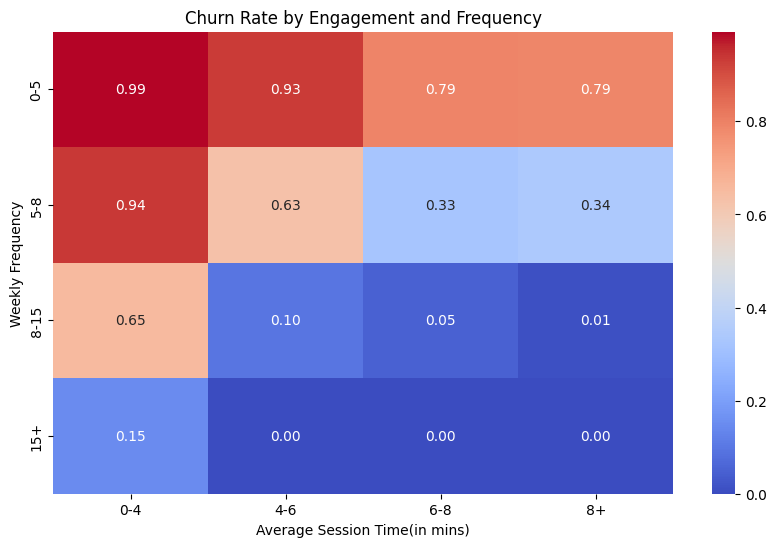

In [19]:
# 绘制热力图
plt.figure(figsize = (10, 6))
sns.heatmap(data = pivot_table, annot = True,fmt = '.2f', cmap = 'coolwarm')
plt.title('Churn Rate by Engagement and Frequency')
plt.xlabel('Average Session Time(in mins)')
plt.ylabel('Weekly Frequency')
plt.show()

流失率最高的用户群分布在使用时间和使用频率都较短的区间，流失率最低的用户群分布在二者都较高的区间，这是可以预料到的
但令人惊奇是，使用频率好像发挥着更大的作用。从图中我们可以看出，当用户每周的登录次数超过15次时，即使每次的使用时间位于最低区间，用户流失率依然较低。而尽管每次的使用时间超过75%的用户，当使用频率每周只有0-5次时，依然显示出较高的流失率。

### 待解决的代码问题：

1. ```df.groupby(['age_group','subscription_status']).size().unstack(fill_value = 0)``` 混淆了unstack() 和reset_index().

2. 为什么第一组里的bar中间会有一个0？怎么解决？

### 解决方法：
1.
```reset_index()``` is used to move indexes into columns.(**Flatten index**)

```unstack()``` is used to **pivot one level** of the multi-index into column(always the second one)

2.
没有彻底解决。暂时先用```if count > 0```把0消除掉了。但没找到根本原因。初步探索了一下，好像存在height和width都为0的非任何一个real combination的bars，虽然不知道为什么.

In [20]:
# The churn situation of different age group
df.groupby(['age_group','subscription_status']).size().unstack(fill_value = 0)

subscription_status,churned,subscribed
age_group,,
18-34,103,262
35 and over,237,171
under 18,107,120


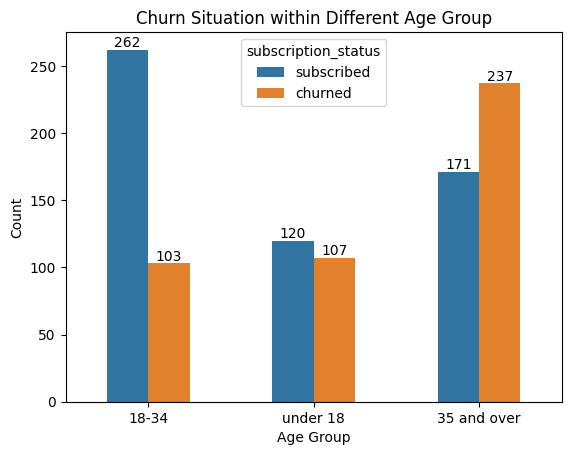

In [22]:
# The churn situation of different age group
ax = sns.countplot(df, x = 'age_group', hue = 'subscription_status', width = 0.5)
plt.title('Churn Situation within Different Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
for p in ax.patches:
    count = int(p.get_height())
    if count > 0:
        ax.annotate(
            f'{count}',
            (p.get_x() + p.get_width()/2, count),
            ha = 'center', va = 'bottom', fontsize = 10
        )

值得注意的用户群体是35岁及以上这一年龄组，退订率高达58%，且选择结束订阅的用户要多于选择续订的用户。

退订比率最小的用户群是18-34岁，退订率为28.2%。

18岁以下的用户群订阅情况较为稳定，退订率和续订率基本处于同一水平线。

### Step2: 构建用户画像
思路：
1. 利用KMeans进行用户分层

2. 结合变量，构建用户标签

3. 比较不同类型用户的流失率

In [4]:
# Map the target binary variable
df['subscription_status'] = df['subscription_status'].map({'churned': 1, 'subscribed': 0})

# Separate the dataset into input X and output y.
X = df.drop(['subscriber_id', 'subscription_status'], axis = 1)
y = df['subscription_status']

# Check the result
print('The shape of input X is:', X.shape)
print('The shape of output y is:', y.shape)

The shape of input X is: (1000, 4)
The shape of output y is: (1000,)


In [5]:
# KMeans clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Choose the used features 
segmentation = X.drop('age_group', axis = 1)
segmentation.head()

,engagement_time,engagement_frequency,weekly_engagement
index,,,
0,5.55,7,38.85
1,5.12,12,61.44
2,4.25,4,17.00
3,8.54,15,128.10
4,12.12,20,242.40


In [6]:
# Normalize variables before implementing KMeans
scaler = StandardScaler()
segmentation_normalized = scaler.fit_transform(segmentation)

# Check the normalization result
print('The mean is:', scaler.mean_.squeeze())
print('The std is:', scaler.scale_.squeeze())
print(f"Peak to Peak range by column in  segmentation:{(segmentation.max() - segmentation.min()).values}")   
print(f"Peak to Peak range by column in Normalized segmentaion:{np.ptp(segmentation_normalized,axis=0)}")

The mean is: [ 6.18003  9.978   67.11363]
The std is: [ 2.75578731  6.23374013 55.74720878]
Peak to Peak range by column in  segmentation:[ 16.76  45.   369.  ]
Peak to Peak range by column in Normalized segmentaion:[6.08174656 7.21878023 6.61916548]


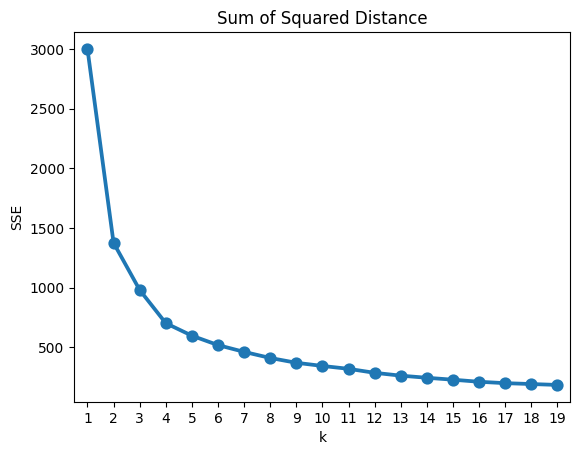

In [12]:
# Use elbow method to explore the number of clusters
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters = k, random_state = 1)
    kmeans.fit(segmentation_normalized)
    sse[k] = kmeans.inertia_

sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.title('Sum of Squared Distance')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()

In [7]:
# Apply kmeans with 4 clusters
kmeans = KMeans(n_clusters = 4, random_state = 1)
kmeans.fit(segmentation_normalized)

# Analyze average feature values and counts per cluster
segmentation['cluster_id'] = kmeans.labels_

analysis = segmentation.groupby('cluster_id').agg({
    'engagement_time': ['mean'],
    'engagement_frequency': ['mean'],
    'weekly_engagement':['mean'],
    'cluster_id': ['count']                                                 
}).rename(columns = {'cluster_id': 'cluster'}).round(0)
analysis

,engagement_time,engagement_frequency,weekly_engagement,cluster
,mean,mean,mean,count
cluster_id,,,,
0,4.0,5.0,20.0,395
1,6.0,17.0,97.0,205
2,8.0,7.0,58.0,251
3,10.0,17.0,167.0,149


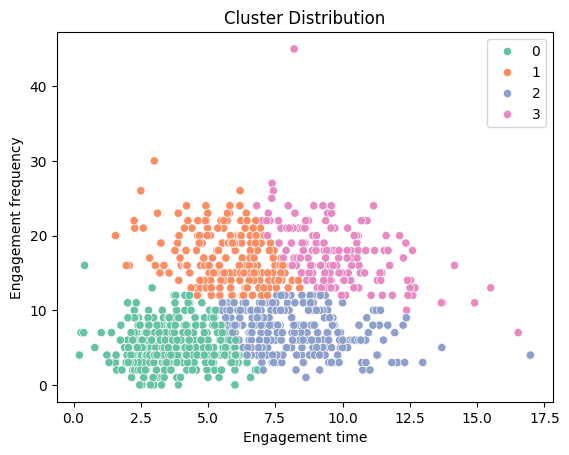

In [14]:
# Visualize the clusters
sns.scatterplot(segmentation, x = 'engagement_time', y = 'engagement_frequency', hue = 'cluster_id', palette ='Set2')
plt.title('Cluster Distribution')
plt.xlabel('Engagement time'); plt.ylabel('Engagement frequency')
plt.legend(title = '')
plt.show()

利用KMeans聚类算法， 将用户分层

cluster0: 低时长，低频率，低总活跃度的用户

cluster1: 中时长，高频率，较高总活跃度的用户

cluster2: 高时长，中频率，中总活跃度的用户

cluster3: 高时长，高频率，高总活跃度的用户

### 待解决问题：
```segmentation_with_age['subscription_status'] = df['subscription_status']```如果放在groupby()之后，即放在下下一个cell里，就会匹配错误。但是如果以后过程复杂的话，怎么能清醒地知道没有变更过原结构呢？所以有没有保险的对应方法？

In [8]:
# Add back interpretable variable
import copy
segmentation_with_age = copy.deepcopy(X)
segmentation_with_age['cluster_id'] = kmeans.labels_

# Add subscription_status back
segmentation_with_age['subscription_status'] = df['subscription_status']

# Uncover age group distribution within each cluster
segmentation_with_age.groupby(['cluster_id', 'age_group']).size().unstack(fill_value = 0)

age_group,18-34,35 and over,under 18
cluster_id,,,
0,48,256,91
1,39,96,70
2,150,40,61
3,128,16,5


clsuter0: 对于低时长，低频率，低总活跃度的用户群，其主要年龄层为35岁及以上。

cluster1: 对于中时长，高频率，较高总活跃度的用户群，其主要年龄层为35岁及以上，和18岁以下的群体。

cluster2: 对于高时长，中频率，中总活跃度的用户群，其主要年龄层为18-34岁。

cluster3: 对于高时长，高频率，高总活跃度的用户群，其主要年龄层为18-34岁。

In [9]:
# 计算和比较各类用户群的流失率

churn_by_cluster = segmentation_with_age.groupby('cluster_id')['subscription_status'].agg(['mean', 'count'])
churn_by_cluster = churn_by_cluster.rename(columns={'mean': 'churn_rate'})
churn_by_cluster = churn_by_cluster.round(2)

churn_by_cluster

,churn_rate,count
cluster_id,,
0,0.88,395
1,0.02,205
2,0.37,251
3,0.01,149


cluster0 易流失型中年客户：流失高，时长低，频率低，总活跃度低，流失率为88%，用户占比39.5%。

cluster1 忠诚型中年/少年用户：流失低，时长中，频率高，总活跃度较高，流失率为2%，用户占比20.5%。

cluster2 稳定型青年用户：流失较低，时长高，频率中，总活跃度中等，流失率为37%，用户占比25.1%。

cluster3 沉浸型青年用户：流失低，时长高，频率高，总活跃度高，流失率为1%，用户占比14.9%


In [18]:
# Create cluster profile
cluster_profile = segmentation_with_age.groupby('cluster_id').agg({
    'subscription_status': [('churn_rate','mean')],
    'engagement_time': ['mean'],
    'engagement_frequency': ['mean'],
    'age_group': [('mode', lambda x: x.mode()[0])],
    'cluster_id': ['count']
}).rename(columns = {'cluster_id': 'cluster'}).round(2)
cluster_profile

,subscription_status,engagement_time,engagement_frequency,age_group,cluster
,churn_rate,mean,mean,mode,count
cluster_id,,,,,
0,0.88,3.74,5.26,35 and over,395
1,0.02,5.74,17.05,35 and over,205
2,0.37,8.23,7.20,18-34,251
3,0.01,9.80,17.44,18-34,149


易流失型中年客户在用户群中占比最大，同时也是流失率最高的一组，其使用时长和上线频率都很低，考虑可能是平台内容对该类客户不具有吸引力，不属于他们的常用软件。

忠诚型中年/少年用户，虽然单次时长不高，但上线频率很高，不断累积使总活跃度也很高。可能该平台是这一群体的常用软件，闲着没事儿就喜欢打开刷一刷。

稳定型青年客户，单次时长高，但上线频率不高，考虑可能是具有吸引力的平台内容较少，所以用户每次登录若找到自己想看的内容，就会看很久，但由于用户感兴趣的内容并不多，所以用户的上线频率较低。不属于该类客户的常用软件，可能属于补充型软件。用户流失的原因可能是，认为自己使用频率不高，所以开通会员并不划算。

沉浸型青年客户，单次时长和上线频率都很高的一类客户群体，属于软件的“超级粉丝”，平台内容大部分都对其胃口，所以只要登录，就能刷到想看的看很久。

**可以明显看到，在登录频率这块，应该是存在可能的断点的，需要研究一下**

### 待解决问题：
```right = False``` 什么意思?

### 解答
Default is```right = True```, means **interval is right-inclusive** ,eg: (a, b].

When we set ```right= False```, **interval is left-inclusive**, eg: [a, b).

/var/folders/2x/v2nfhk6s183c6sb3zklf20300000gn/T/ipykernel_18037/2713699438.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_freq = df.groupby('freq_group')['subscription_status'].mean()


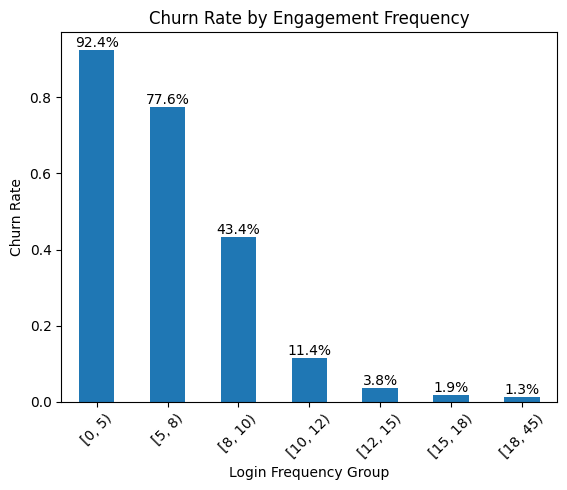

In [32]:
# 分箱登录频率，查看每组流失率
df['freq_group'] = pd.cut(df['engagement_frequency'], 
                          bins=[0,5,8,10,12,15,18,45], 
                          right=False)

# 每组的流失率
churn_by_freq = df.groupby('freq_group')['subscription_status'].mean()

# 可视化：不同登录频率组与流失率的柱状图
ax = churn_by_freq.plot(kind='bar', title='Churn Rate by Engagement Frequency')
for p in ax.patches:
    percentage = ((p.get_height()) * 100).round(1)
    ax.annotate(
        f'{percentage}%',
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha = 'center', va = 'bottom', fontsize = 10
    )
plt.ylabel('Churn Rate')
plt.xlabel('Login Frequency Group')
plt.xticks(rotation=45)
plt.show()

根据各组的登录频率平均数和登录频率的位置量度来划分区间。

首先88%流失率组的平均周登录次数为5次，37%流失率组的平均周登录次数为7次，2%和1%流失率组的平均周登录次数均约为17次。

再看总体的登录次数分布，下四分位数为5次，中位数为8次，上四分位数为15次。

猜测在5-8次，8-15次区间内可能存在断点。

由上图可知，当用户周平均登录次数少于8次时，流失率波动在较高位置。当**周平均登录次数超过8次时**，**流失率骤降到40%左右**；当用户使用频率**超过10次**时，**流失率显著降低至10%左右**；当登录次数超过12次时，用户流失率波动在很低的位置。


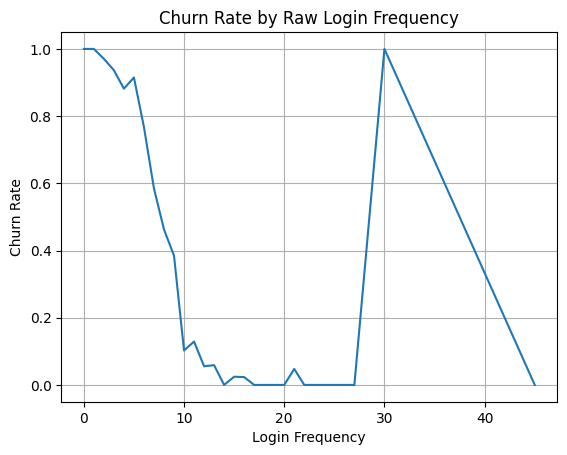

In [30]:
# 进一步验证：登录频率与流失率的折线图
churn_by_freq_line = df.groupby('engagement_frequency')['subscription_status'].mean()
churn_by_freq_line.plot()
plt.title('Churn Rate by Raw Login Frequency')
plt.xlabel('Login Frequency')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.show()

### Step3: 训练预测模型，检验上述分析结果

In [33]:
# Train 3 models to explore(Logistic, Decision Tree, Random Forest)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [34]:
# Split dataset into 3 sets(training, cross-validation, test)
X_train, X_, y_train, y_ = train_test_split(X, y, test_size = 0.4, random_state = 1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size = 0.5, random_state = 1)
del X_, y_

# Check the splitting results
print(f"The shape of X_train is: {X_train.shape}")
print(f"The shape of y_train is: {y_train.shape}\n")
print(f"The shape of X_cv is: {X_cv.shape}")
print(f"The shape of y_cv is: {y_cv.shape}\n")
print(f"The shape of X_test is: {X_test.shape}")
print(f"The shape of y_test is: {y_test.shape}")

The shape of X_train is: (600, 4)
The shape of y_train is: (600,)

The shape of X_cv is: (200, 4)
The shape of y_cv is: (200,)

The shape of X_test is: (200, 4)
The shape of y_test is: (200,)


In [35]:
# Preprocess data for numerical and categorical variables
cat_cols = ['age_group']
num_cols = ['engagement_time','engagement_frequency','weekly_engagement']

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(sparse_output = False), cat_cols),
        ('num', StandardScaler(), num_cols)       
    ])

preprocessor.set_output(transform = 'pandas')

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_cv_preprocessed = preprocessor.transform(X_cv)

# Check the result
X_train_preprocessed.head()

,cat__age_group_18-34,cat__age_group_35 and over,cat__age_group_under 18,num__engagement_time,num__engagement_frequency,num__weekly_engagement
index,,,,,,
371,0.0,1.0,0.0,-1.052648,-0.462631,-0.780614
45,0.0,0.0,1.0,0.575796,-1.119234,-0.782238
560,1.0,0.0,0.0,-0.413825,0.686424,0.077099
748,1.0,0.0,0.0,1.631884,0.522273,1.285440
419,0.0,1.0,0.0,0.553640,1.014725,1.016198


In [36]:
# 1. Logistic Regression Model
model1 = LogisticRegression()
model1.fit(X_train_preprocessed, y_train)

# Calculate the accuracy score
train_score = model1.score(X_train_preprocessed, y_train)
test_score = model1.score(X_cv_preprocessed, y_cv)
print('The train_score:', train_score)
print('The test_score:', test_score)

The train_score: 0.8983333333333333
The test_score: 0.905


In [39]:
pd.DataFrame({
    'Feature': X_train_preprocessed.columns,
    'Coefficient': model1.coef_[0] 
})

,Feature,Coefficient
0,cat__age_group_18-34,0.388052
1,cat__age_group_35 and over,-0.307203
2,cat__age_group_under 18,-0.081973
3,num__engagement_time,-0.663351
4,num__engagement_frequency,-2.175263
5,num__weekly_engagement,-1.918500


```model.coef_``` returns the coefficients for each feature(2D array), eg:array([[0.8, -1.2, 0.3]]).

```model_intercept_```returns the constant term (b).

Using ```model1.coef_[0]``` to extract the first row of an array(原来看过的Slice).存在这一设计的原因是尚未学习过的multi-class classification.

以上显示的为逻辑回归模型的相关参数，可以看出，**周平均登录次数对于用户流失率影响最大**，其参数绝对值约为2.2。其次为总活跃度，参数绝对值约为2.这是可以理解的，因为**当用户高频使用时**，**说明该视频平台对其是非常有吸引力的**，或者说该平台**是用户的惯性使用软件**。所以即使单次使用时长并不高，但累积的总活跃度会很高。

而相对于前两者，**用户单次使用时长对流失率的解释性较低**，这符合前面我们的观察，即使用户显示出较高的使用时长，但依然可能会有较大的流失率。**这说明**该视频平台不属于用户经常使用的软件，即**当用户想要搜索某一视频资源或者想短暂地放松时，其第一选择不是该平台**。这**可能指出该平台的会员视频内容没有满足这部分用户的大部分使用需求**，用户只有在特定情况下才会选择使用。

In [18]:
# 2. Decision Tree Model
model2 = DecisionTreeClassifier(max_depth = 3)
model2.fit(X_train_preprocessed, y_train)

# Calculate the accuracy score
train_score = model2.score(X_train_preprocessed, y_train)
test_score = model2.score(X_cv_preprocessed, y_cv)
print('The train_score:', train_score)
print('The test_score:', test_score)

The train_score: 0.9066666666666666
The test_score: 0.895


In [19]:
# 3. Random Forest Ensemble
model3 = RandomForestClassifier(max_depth = 3, random_state = 1)
model3.fit(X_train_preprocessed, y_train)

# Calculate the accuracy score
train_score = model3.score(X_train_preprocessed, y_train)
test_score = model3.score(X_cv_preprocessed, y_cv)
print('The train_score:', train_score)
print('The test_score:', test_score)

The train_score: 0.905
The test_score: 0.915


Based on the three exploratory models, the accuracy scores of **Random forest ensemble** are better for both the training and cross validation set. Then I want to **introduce more hyperparameters and see which combination gives the best performance.**

In [20]:
# Try different hyperparamters' combinations on model3
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [40, 50, 60],
    'max_features': ['sqrt', 3, 4],
    'max_depth' :[3, 4, 5],
    'min_samples_split': [2, 3, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state = 1), param_grid = param_grid, cv = 5)
grid_search.fit(X_train_preprocessed, y_train)
grid_search.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 50}

In [21]:
# Calculate the accuracy score of the best combo's model
train_score = grid_search.best_estimator_.score(X_train_preprocessed, y_train)
val_score = grid_search.best_estimator_.score(X_cv_preprocessed, y_cv)
print('The train_score:', train_score)
print('The test_score:', test_score)

The train_score: 0.9116666666666666
The test_score: 0.915


In [22]:
# Retrain the best model on a larger dataset(X_train + X_cv)
# Clone the hyperparameters with max_depth of 4 and n_estimators of 50
from sklearn.base import clone
final_model = clone(grid_search.best_estimator_)

# Train to get the parameters
final_model.fit(pd.concat([X_train_preprocessed, X_cv_preprocessed]), pd.concat([y_train, y_cv]))

# Calculate the accuracy score
train_final_score = final_model.score(pd.concat([X_train_preprocessed, X_cv_preprocessed]), pd.concat([y_train, y_cv]))
print('The train score is:', train_final_score)

# Evaluate the true accuracy score
X_test_preprocessed = preprocessor.transform(X_test)
score = final_model.score(X_test_preprocessed, y_test) 
print(f"The accuracy score of the final Random Forest model (50 estimators, maximum depth of 4, and minimum samples split of 5) is: {score}")

The train score is: 0.91125
The accuracy score of the final Random Forest model (50 estimators, maximum depth of 4, and minimum samples split of 5) is: 0.905
